In [1]:

%matplotlib notebook

import numpy as np
from multitools import get_w_bases
from multitools import create_mgd, prepare_ground
from multitools import predict_pose
from multitools import visualize_intersection, visualize_all_cigars





In [2]:

if __name__ == '__main__':
    
    # Number of points, per axis, to evaluate
    nb_pts = 101
    
    nb_s = 1
    w_x, w_y, w_z = get_w_bases(nb_s)
        
    e_d = np.zeros((nb_s, nb_s, nb_s)) # error in euler distance in [cm]
    for i in range(nb_s):
        for j in range(nb_s):
            for k in range(nb_s):
                
                # Object's pose in world space
                w_pose = np.array([w_x[i], w_y[j], w_z[k]])  
                
                w_pose = [-0.35, 0.1, 0.60]
                
                print("For w_pose = ({:.3f}, {:.3f}, {:.3f})".format(w_pose[0], w_pose[1], w_pose[2]))
                

                # Mean array and covariance matrix in virtual camera space
                μ = np.array([0,0,-0.6])
                Σ = np.array([[0.01,0,0],[0,0.01,0],[0,0,1.2]])    

                # Go to virtual space and get data (matrices) in the process
                r_trl, r2w, v2r, r_obj_poses, v_obj_poses, r_cam_poses = prepare_ground(w_pose)

                # Create gaussians in virtual space and transform them into world space
                new_μ, rv = create_mgd(μ, Σ, r_trl, r2w, v2r, v_obj_poses)

                # Do predictions
                x, y, z, p, idx, e_d[i,j,k] = predict_pose(nb_pts, rv, new_μ[:,k],  w_pose)

For w_pose = (-0.350, 0.100, 0.600)
vir_z_123 = (-1.183, -1.199, -0.935)
Joint probabilities obtained after: 601 [ms].
Final Threshold : 5.030
Prediction: (-0.358, 0.114, 0.596)
dx = 0.785 | dy = 1.414 | dz = 0.352 in cm
Error: 1.655 [cm]




<IPython.core.display.Javascript object>


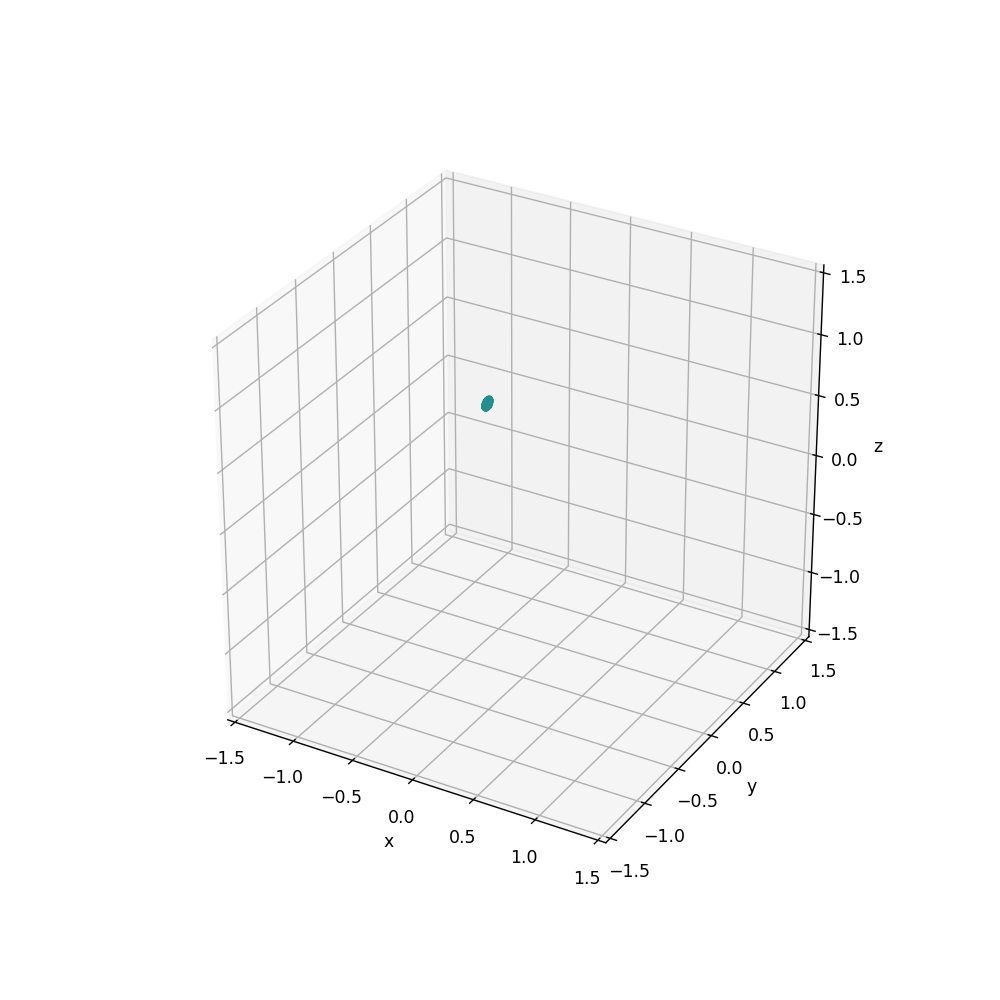

In [3]:
%matplotlib notebook
visualize_intersection(x, y, z, p, idx, w_pose)

<IPython.core.display.Javascript object>


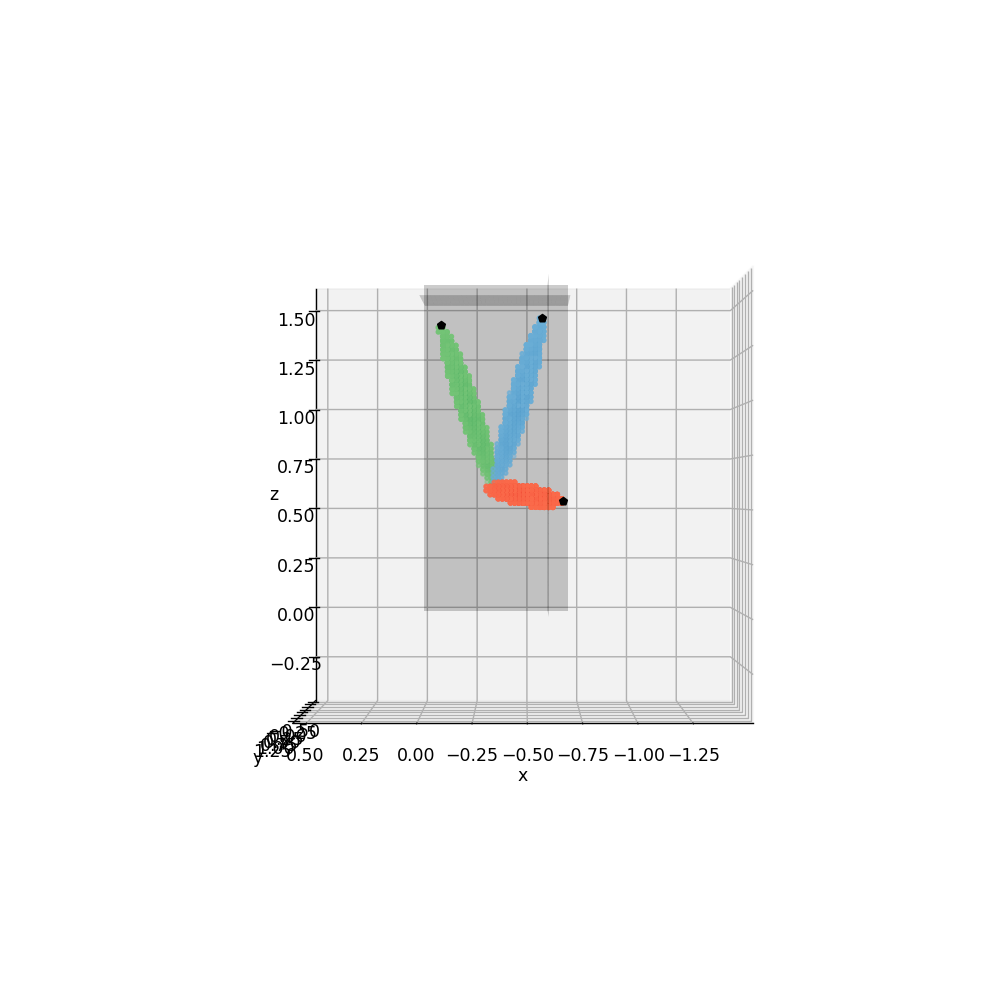

Joint probabilities obtained after: 0 seconds.
Joint probabilities obtained after: 0 seconds.
Joint probabilities obtained after: 0 seconds.


In [4]:
visualize_all_cigars(nb_pts, rv, new_μ, 'xz', r_cam_poses)

<IPython.core.display.Javascript object>


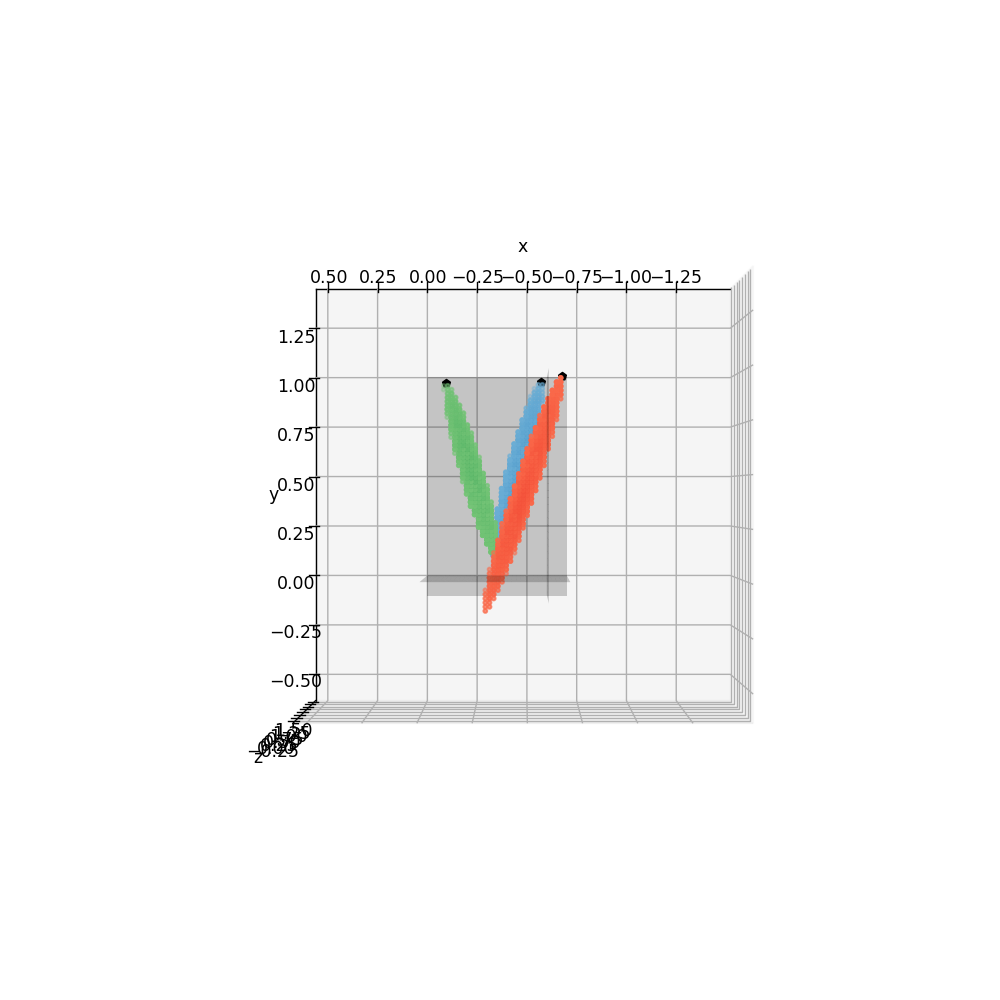

Joint probabilities obtained after: 0 seconds.
Joint probabilities obtained after: 0 seconds.
Joint probabilities obtained after: 0 seconds.


In [5]:
visualize_all_cigars(nb_pts, rv, new_μ, 'xy', r_cam_poses)

<IPython.core.display.Javascript object>


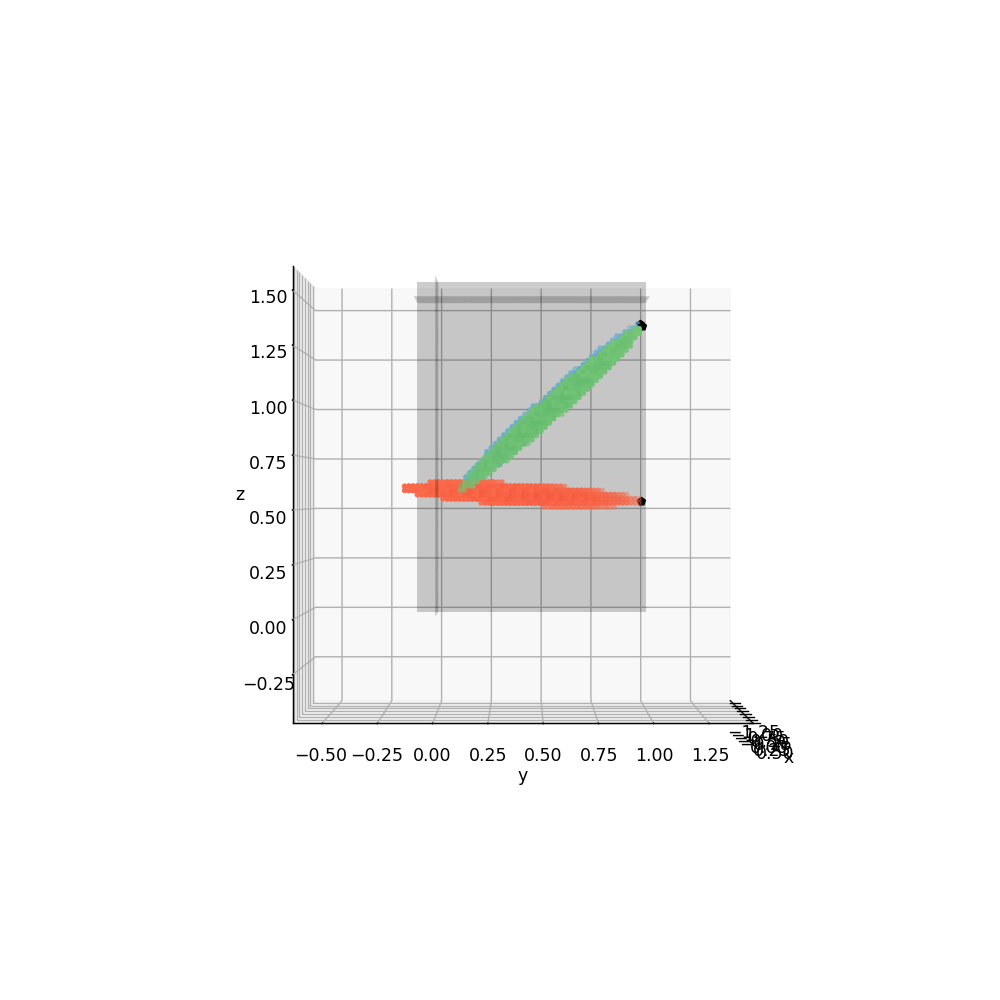

Joint probabilities obtained after: 0 seconds.
Joint probabilities obtained after: 0 seconds.
Joint probabilities obtained after: 0 seconds.


In [6]:
visualize_all_cigars(nb_pts, rv, new_μ, 'yz', r_cam_poses)

<IPython.core.display.Javascript object>


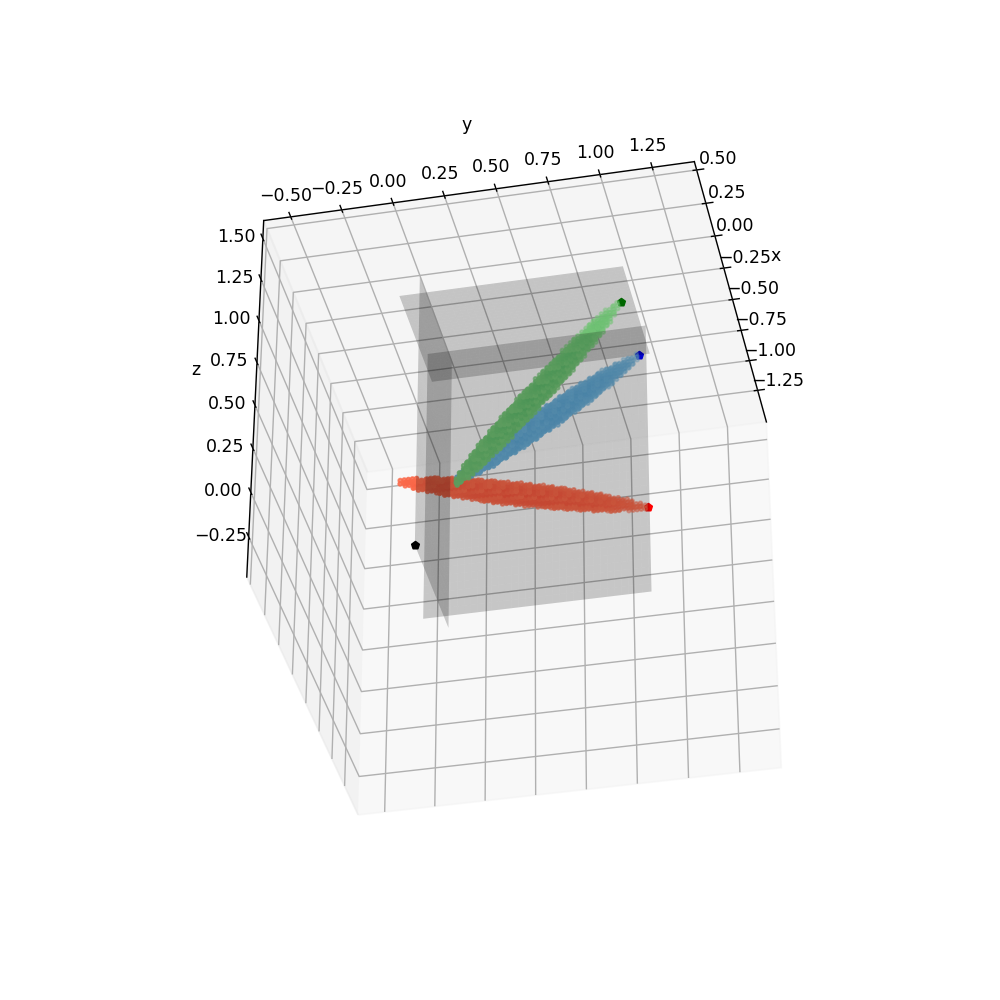

Joint probabilities obtained after: 0 seconds.
Joint probabilities obtained after: 0 seconds.
Joint probabilities obtained after: 0 seconds.


In [3]:
visualize_all_cigars(nb_pts, rv, new_μ, 'im', r_cam_poses)

<IPython.core.display.Javascript object>


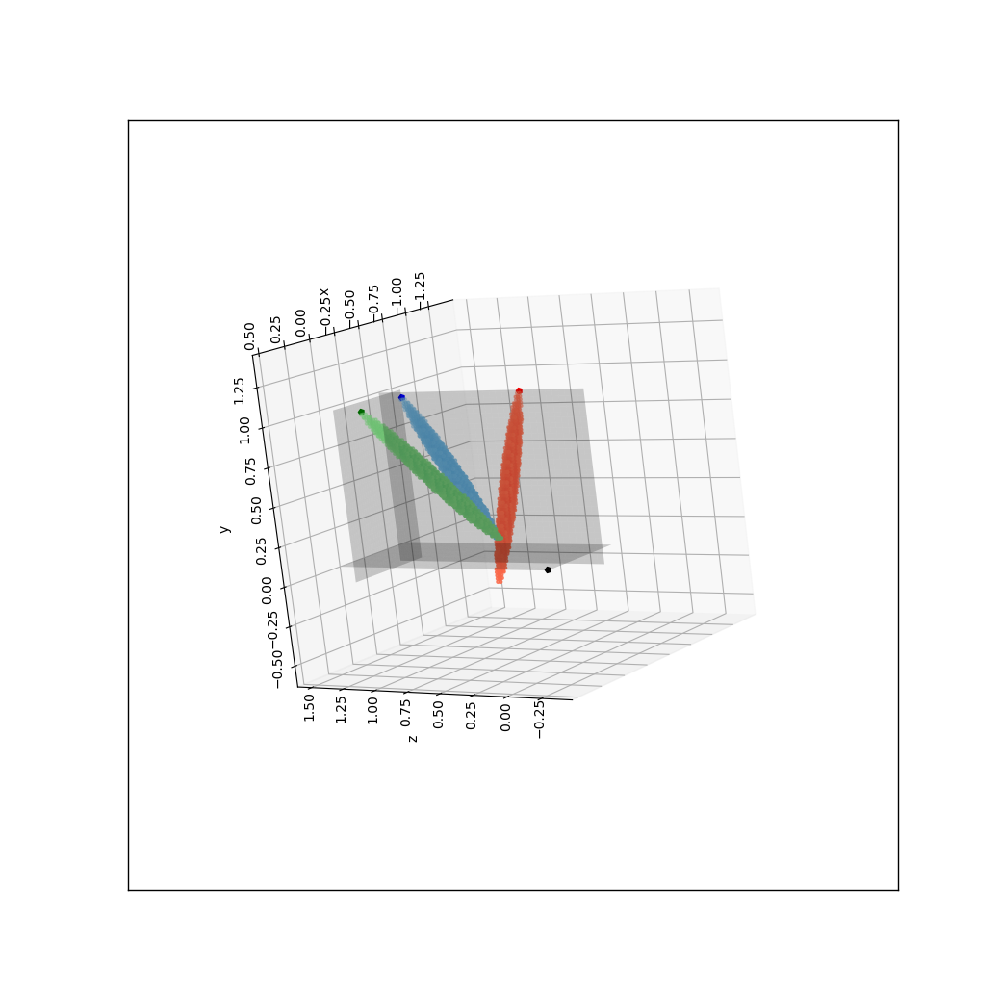

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
colorImage  = Image.open("Example.png") 
transposed  = colorImage.transpose(Image.ROTATE_90)
plt.imshow(transposed)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)